### Imports

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### Load Likelihood Results

In [ ]:
control = torch.load("truthful_control.pt")
tuned = torch.load("truthful_tuned.pt")
syco_control = torch.load("syco_truth_control.pt")
syco_steer = torch.load("syco_truth_steer.pt")
myopia_control = torch.load("myopia_control.pt")
myopia_steer = torch.load("myopia_steer.pt")



hall_control = torch.load("hallucination_control.pt")
hall_steer = torch.load("hallucination_steer.pt")
neg_hall_control = torch.load("neg_hallucination_control.pt")
neg_hall_steer = torch.load("neg_hallucination_steer.pt")



hall_control_caa = torch.load("hall_1.5_control.pt")
hall_steer_caa = torch.load("hall_1.5_steer.pt")
neg_hall_control_caa = torch.load("hall_1.5_neg_control.pt")
neg_hall_steer_caa = torch.load("hall_1.5_neg_steer.pt")

corr_control = torch.load("corrigible_control.pt")
corr_steer = torch.load("corrigible_steer.pt")

<ipython-input-2-c93e63f8a52b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  control = torch.load("truthful_control.pt")
<ipython-input-2-c93e63f8a52b>:2: FutureWarning: 

### Metric and Visualization Functions

In [ ]:
from matplotlib.colors import ListedColormap

def plot_metric(ctrl, exp, title, ctrl_name, exp_name):
  # First half represents behavior matching behavior
  ctrl_match = ctrl[:int(ctrl.shape[0]/2)]
  ctrl_non_match = ctrl[int(ctrl.shape[0]/2):]
  exp_match = exp[:int(exp.shape[0]/2)]
  exp_non_match = exp[int(exp.shape[0]/2):]

  # Sort both control groups
  ctrl_match_ind = torch.argsort(ctrl_match)
  ctrl_non_match_ind = torch.argsort(ctrl_non_match)
  ctrl_srt = torch.cat([ctrl_non_match[ctrl_non_match_ind], ctrl_match[ctrl_match_ind]])

  # Rearrange exp to match the control sorting
  exp_srt = torch.cat([exp_non_match[ctrl_non_match_ind], exp_match[ctrl_match_ind]])

  # Rescale
  ctrl_srt = (-1 * ctrl_srt) / ctrl_srt.max()
  exp_srt = (-1 * exp_srt) / exp_srt.max()

  # Set plot limits
  plt.xlim(-2,ctrl.shape[0]+1)
  plt.ylim(torch.cat([ctrl_srt,exp_srt]).min()-0.2,torch.cat([ctrl_srt,exp_srt]).max()+0.2)

  # Calculate Quartiles
  negative_samples = ctrl_srt[:len(ctrl_srt)//2]  # Get top negative side
  positive_samples = ctrl_srt[len(ctrl_srt)//2:]  # Bottom Positive side

  # Select the first 25% 50% 75% of indices
  neg_bounds = [np.percentile(negative_samples.numpy(), 75), max(negative_samples).item()]
  pos_bounds = [min(positive_samples).item(), np.percentile(positive_samples.numpy(), 25)]

  cmap = ListedColormap([   '#ffeb99'])  # You can modify these colors
  plt.fill_betweenx(neg_bounds, -2, negative_samples.shape[0]-1, color=cmap(0), alpha=0.5)
  plt.fill_betweenx(pos_bounds, negative_samples.shape[0]-1, ctrl.shape[0]+1, color=cmap(0), alpha=0.5)

  # Create the scatter plot
  plt.scatter(np.arange(exp.shape[0]), ctrl_srt, color='blue', label=ctrl_name, s=50, alpha=0.8)
  plt.scatter(np.arange(exp.shape[0]), exp_srt, color='red', label=exp_name, s=50, alpha=0.8)

  # Add a dotted vertical line
  plt.axvline(x=negative_samples.shape[0]-1, color='black', linestyle='--', linewidth=1)

  plt.legend(loc='upper left')

  # Show the plot
  plt.savefig(f"{title}.png")

  plt.show()



In [ ]:
def calc_steer_metric(ctrl, exp):


  # Split and renormalize into behavior groups
  ctrl_match = ctrl[:int(ctrl.shape[0]/2)] / (-1*ctrl.max())
  ctrl_non_match = ctrl[int(ctrl.shape[0]/2):] / (-1*ctrl.max())

  exp_match = exp[:int(exp.shape[0]/2)] / (-1*exp.max())
  exp_non_match = exp[int(exp.shape[0]/2):] / (-1*exp.max())

  # Sort groups based on control
  ctrl_match_ind = torch.argsort(ctrl_match)
  ctrl_non_match_ind = torch.argsort(ctrl_non_match, descending=True)

  ctrl_match = ctrl_match[ctrl_match_ind]
  ctrl_non_match = ctrl_non_match[ctrl_non_match_ind]

  exp_match = exp_match[ctrl_match_ind]
  exp_non_match = exp_non_match[ctrl_non_match_ind]

  match_diff = exp_match - ctrl_match
  non_match_diff = ctrl_non_match - exp_non_match

  # Measure metric include more and more quartiles from Q4 to Q1
  scores = []
  for i in range(1,5):
    match_sub = match_diff[:int(match_diff.shape[0] * i/4)]
    non_match_sub = non_match_diff[:int(non_match_diff.shape[0] * i/4)]


    # Give credit for positive difference in match and negative difference in non-match
    scores.append((round(match_sub.mean().item(),4), round(non_match_sub.mean().item(),4)))

  return scores

### Results

### ITI For Truthfulness

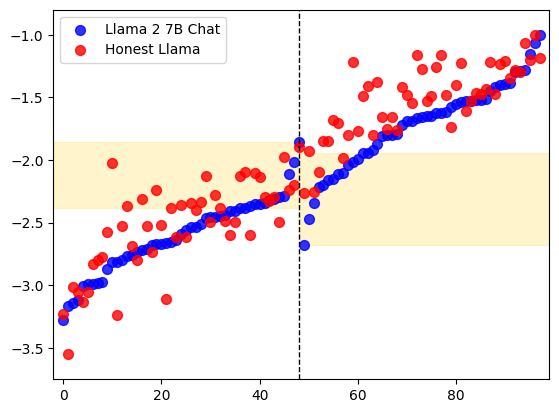

In [ ]:
plot_metric(control, tuned, 'Likehlihoods of Hallucination Then Truthful Continuations', 'Llama 2 7B Chat', 'Honest Llama')

In [ ]:
calc_steer_metric(control, tuned)

[(0.3402, -0.0289), (0.3011, -0.0521), (0.2537, -0.079), (0.202, -0.0812)]

### Myopia CAA

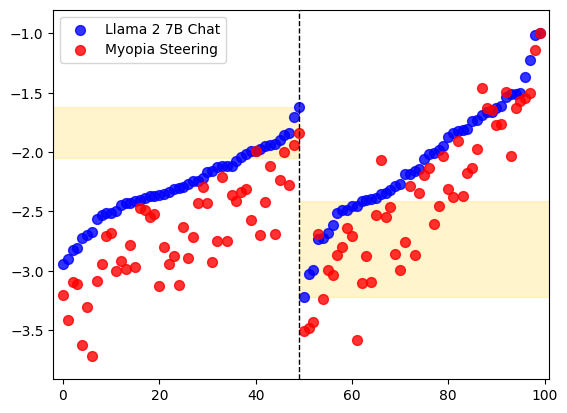

In [ ]:
plot_metric(myopia_control.flip(0), myopia_steer.flip(0), 'Likelihoods of Non Myopic Then Myopic Continuations', 'Llama 2 7B Chat', 'Myopia Steering')

In [ ]:
calc_steer_metric(myopia_control.flip(0), myopia_steer.flip(0))

[(-0.3814, 0.366), (-0.3813, 0.3737), (-0.367, 0.3921), (-0.2972, 0.4141)]

### Hallucination CAA

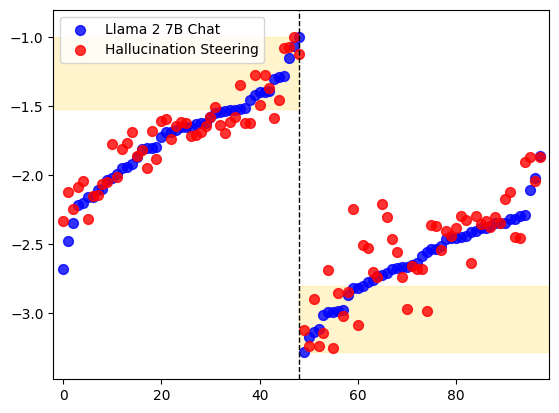

In [ ]:
plot_metric(hall_control.flip(0), hall_steer.flip(0), 'Likelihoods of Truthful Then Hallucination Continuations', 'Llama 2 7B Chat', 'Hallucination Steering')

In [ ]:
calc_steer_metric(hall_control.flip(0), hall_steer.flip(0))

[(0.0436, 0.0252), (0.0806, 0.0285), (0.0564, 0.0042), (0.0581, -0.0231)]

### Truthfulness CAA With Negative Hallucination Vector

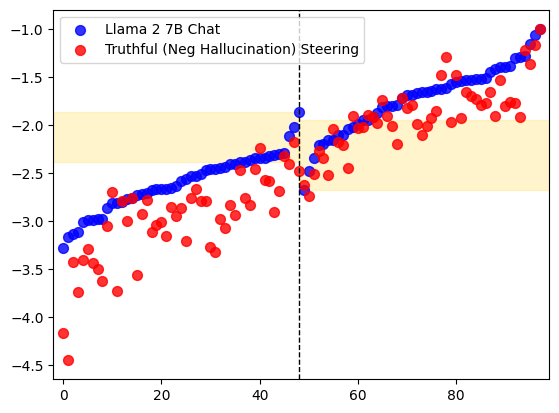

In [ ]:
plot_metric(neg_hall_control, neg_hall_steer, 'Likelihoods of Hallucination Then Truthful Continuations', 'Llama 2 7B Chat', 'Truthful (Neg Hallucination) Steering')

In [ ]:
calc_steer_metric(neg_hall_control, neg_hall_steer)

[(-0.1122, 0.2849), (-0.113, 0.3718), (-0.1322, 0.3528), (-0.1686, 0.3891)]

### Sycophancy CAA

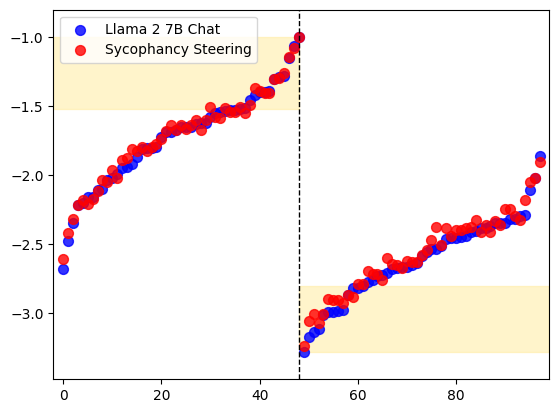

In [ ]:
plot_metric(syco_control.flip(0), syco_steer.flip(0), 'Likelihoods of Truthful Then Hallucination Continuations', 'Llama 2 7B Chat', 'Sycophancy Steering')

In [ ]:
calc_steer_metric(syco_control.flip(0), syco_steer.flip(0))

[(0.0516, 0.0023), (0.04, 0.0007), (0.0441, -0.0081), (0.0377, -0.0108)]

### Hallucination Steering with Different Coefficient


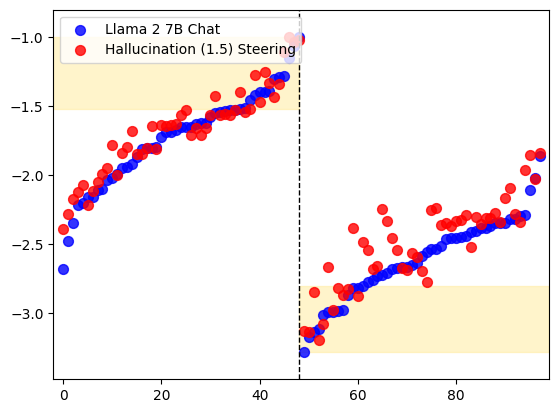

In [ ]:
plot_metric(hall_control_caa.flip(0), hall_steer_caa.flip(0), 'Likelihoods of Hallucination Then Truthful Continuations', 'Llama 2 7B Chat', 'Hallucination (1.5) Steering')

In [ ]:
calc_steer_metric(hall_control_caa.flip(0), hall_steer_caa.flip(0))

[(0.1134, -0.0286), (0.1407, -0.0183), (0.1218, -0.0357), (0.1146, -0.0561)]

### Negative Hallucination Steering with Different Coefficient


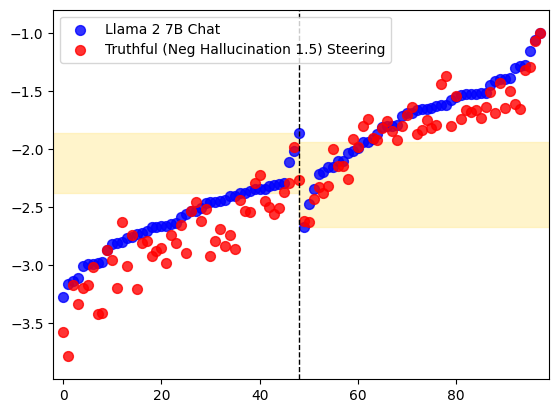

In [ ]:
plot_metric(neg_hall_control_caa, neg_hall_steer_caa, 'Likelihoods of Hallucination Then Truthful Continuations', 'Llama 2 7B Chat', 'Truthful (Neg Hallucination 1.5) Steering')

In [ ]:
calc_steer_metric(neg_hall_control_caa, neg_hall_steer_caa)

[(-0.0571, 0.129), (-0.0325, 0.178), (-0.0504, 0.179), (-0.0767, 0.1888)]

### Corrigible CAA

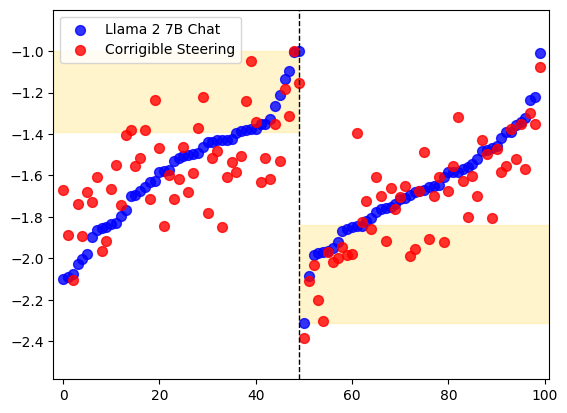

In [ ]:
plot_metric(corr_control, corr_steer, 'Likelihoods of Non-Corrigible Then Corrigible Continuations', 'Llama 2 7B Chat', 'Corrigible Steering')

In [ ]:
calc_steer_metric(corr_control, corr_steer)

[(-0.0618, 0.0876), (-0.0417, 0.0962), (-0.0478, 0.0353), (-0.0616, -0.0151)]